# Evaluate Nightshade approaches

## Imports

In [1]:
import torch
from diffusers import StableDiffusionPipeline
from peft import LoraConfig, get_peft_model, set_peft_model_state_dict
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from py_files.metrics import compute_image_quality_metrics, compute_semantic_metrics, compute_attack_effectiveness, compute_gen_semantic_metrics

torch.backends.cudnn.benchmark = True


methods = ['fgsm', 'pgd', 'original']
BASE_MODEL = 'runwayml/stable-diffusion-v1-5'
GEN_OUT_DIR = 'generated_samples'
PROMPT= 'a photo of a dog'
NUM_IMAGES = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2
%matplotlib inline

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zabibeau/Spring2025/MachineLearning2/nightshade-ml/nightshade_env/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
load checkpoint from /home/zabibeau/.cache/ImageReward/ImageReward.pt
checkpoint loaded


## Evaluating Poisoned Images

### Compute Metrics

In [2]:
poison_metrics_dict = {}
for method in methods:
    poison_dir = f'poisoned_images/{method}/images'
    clean_dir = f'poisoning_candidates/images'

    quality_metrics = compute_image_quality_metrics(poison_dir, clean_dir)
    semantic_metrics = compute_semantic_metrics(poison_dir, clean_dir)
    poison_metrics_dict[f'{method}_quality'] = quality_metrics
    poison_metrics_dict[f'{method}_semantic'] =  semantic_metrics




Computing image quality metrics:   0%|          | 0/300 [00:00<?, ?it/s]

Calculating semantic similarity:   0%|          | 0/300 [00:00<?, ?it/s]

Computing image quality metrics:   0%|          | 0/300 [00:00<?, ?it/s]

Calculating semantic similarity:   0%|          | 0/300 [00:00<?, ?it/s]

Computing image quality metrics:   0%|          | 0/300 [00:00<?, ?it/s]

Calculating semantic similarity:   0%|          | 0/300 [00:00<?, ?it/s]

### Analyze and visualize metrics

In [3]:
def plot_metric_bar(metric_dict, metric_name, title):
    methods = []
    means = []
    stds = []
    
    for method in ['fgsm', 'pgd', 'original']:
        mean, std = metric_dict[f'{method}_quality'][metric_name]
        methods.append(method)
        means.append(mean)
        stds.append(std)
        print(f'{method} {metric_name}: {mean} ± {std}')

    plt.figure(figsize=(8, 5))
    plt.bar(methods, means, yerr=stds, capsize=5)
    plt.title(title)
    plt.ylabel(metric_name)
    plt.xlabel("Method")
    plt.grid(axis='y')
    plt.show()


fgsm LPIPS: 0.3003399635851383 ± 0.12535471650326563
pgd LPIPS: 0.07771425508583585 ± 0.0439543486826372
original LPIPS: 0.13848939521859088 ± 0.06080092539914598


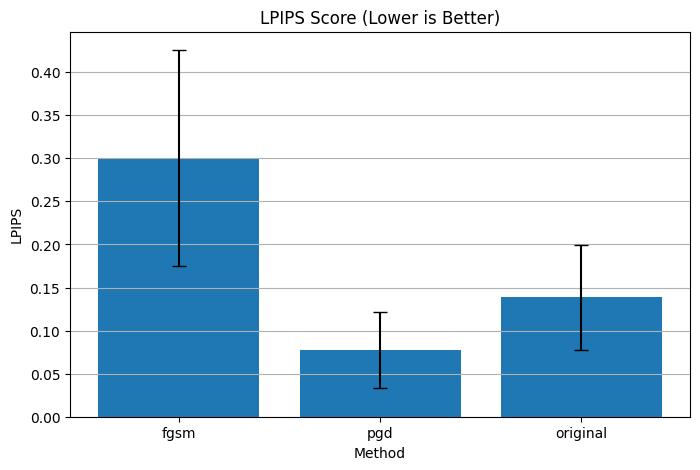

fgsm SSIM: 0.6445953249931335 ± 0.10156316310167313
pgd SSIM: 0.8950061798095703 ± 0.037440646439790726
original SSIM: 0.7928895354270935 ± 0.059487320482730865


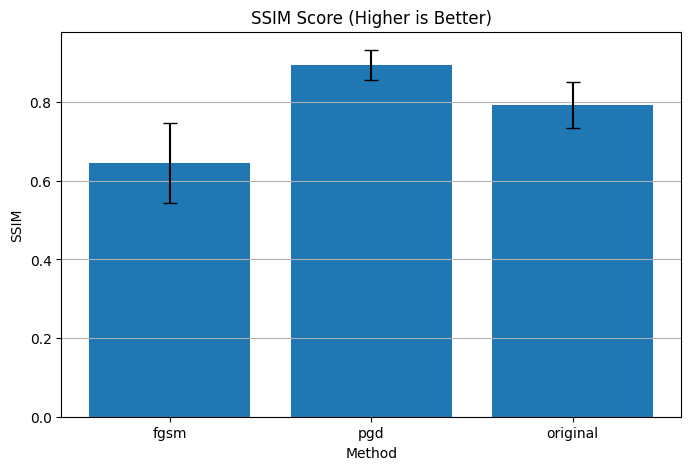

fgsm Cosine Sim: 0.8944521649705325 ± 0.04668212111267503
pgd Cosine Sim: 0.9321426081856286 ± 0.03324458558071288
original Cosine Sim: 0.8993287239921877 ± 0.04520285084747992


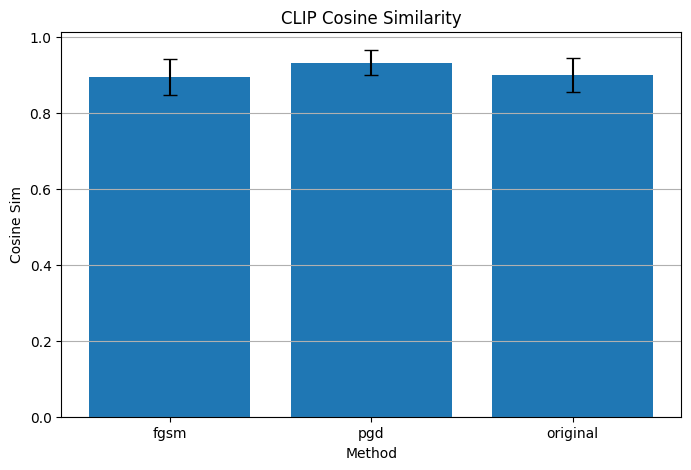

In [4]:
plot_metric_bar(poison_metrics_dict, "LPIPS", "LPIPS Score (Lower is Better)")
plot_metric_bar(poison_metrics_dict, "SSIM", "SSIM Score (Higher is Better)")
plot_metric_bar(poison_metrics_dict, "Cosine Sim", "CLIP Cosine Similarity")

# Poisoned Image Visualization

In [11]:
# Show an example of an image poisoned each way with the original next to it
def show_poisoned_images(image_id, clean_dir, method_dirs, concept='dog'):

    images = []

    clean_path = os.path.join(clean_dir, f'{concept}_{image_id}.jpg')
    images.append((Image.open(clean_path).convert('RGB'), 'clean'))

    for method, dir_path in method_dirs.items():
        poisoned_path = os.path.join(dir_path, f'{method}_{image_id}.jpg')
        img = Image.open(poisoned_path).convert('RGB')
        images.append((img, method))

    plt.figure(figsize=(4*len(images), 4))
    for i, (img, method) in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img)
        plt.title(method)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

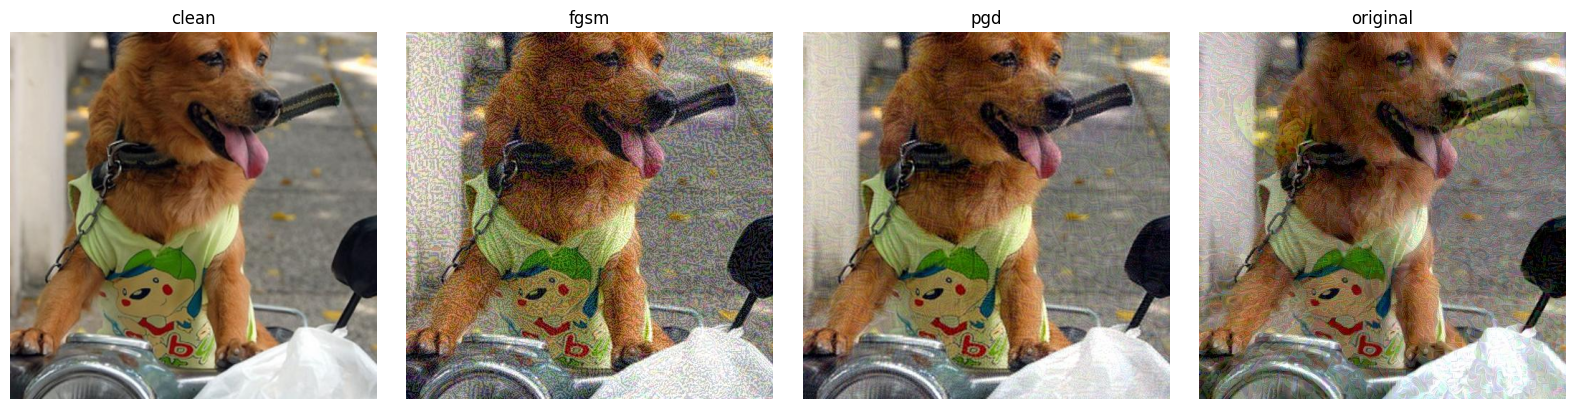

In [12]:
clean_dir = 'poisoning_candidates/images'
method_dirs = {
    'fgsm': 'poisoned_images/fgsm/images',
    'pgd': 'poisoned_images/pgd/images',
    'original': 'poisoned_images/original/images'
}

show_poisoned_images(2337, clean_dir, method_dirs)

## Evaluating Generated Images

### Generate Images

In [13]:
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)
pipe._progress_bar_config = {'disable': True}
methods.insert(0, 'none')
print(methods)
method_progress_bar = tqdm(methods, desc='Methods')
for method in method_progress_bar:
    out_dir = os.path.join(GEN_OUT_DIR, method)
    if method != 'none':
        unet = pipe.unet
        unet = get_peft_model(unet, LoraConfig(
            r=4,
            target_modules=["to_k", "to_q", "to_v", "proj_out"],
            lora_alpha=16,
            lora_dropout=0.1,
        ))

        lora_state_dict = torch.load(os.path.join(f'output_models/{method}_300/lora_adapter', 'pytorch_lora_weights.bin'), map_location='cuda')
        set_peft_model_state_dict(unet, lora_state_dict)

        print("Lora applied sucessfully!")

    os.makedirs(f"{GEN_OUT_DIR}/{method}", exist_ok=True)
    generator = torch.Generator(device=device).manual_seed(5806)

    for i in tqdm(range(NUM_IMAGES), desc='Generating Images'):
        with torch.autocast('cuda'):
            image = pipe(
                prompt=PROMPT,
                num_inference_steps=50,
                guidance_scale=7.5,
                generator=generator
            ).images[0]

        save_path = os.path.join(out_dir, f'{method}_{i}.png')
        image.save(save_path)



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


['none', 'fgsm', 'pgd', 'original']


Methods:   0%|          | 0/4 [00:00<?, ?it/s]

Generating Images:   0%|          | 0/50 [00:00<?, ?it/s]

Lora applied sucessfully!


Generating Images:   0%|          | 0/50 [00:00<?, ?it/s]

Lora applied sucessfully!


Generating Images:   0%|          | 0/50 [00:00<?, ?it/s]

Lora applied sucessfully!


Generating Images:   0%|          | 0/50 [00:00<?, ?it/s]

### Compute Generated Image Metrics

In [24]:
gen_metric_dict = {}
for method in methods:
    if method == 'none':
        continue
    clean_dir = f'{GEN_OUT_DIR}/none'
    poison_dir = f'{GEN_OUT_DIR}/{method}'

    semantic_metrics = compute_gen_semantic_metrics(poison_dir, clean_dir)
    effectiveness = compute_attack_effectiveness(poison_dir, clean_dir)

    gen_metric_dict[f'{method}_semantic'] =  semantic_metrics
    gen_metric_dict[f'{method}_effectiveness'] = effectiveness

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/zabibeau/Spring2025/MachineLearning2/nightshade-ml/nightshade_env/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth
load checkpoint from /home/zabibeau/.cache/ImageReward/ImageReward.pt
checkpoint loaded


Calculating semantic similarity:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating attack effectiveness:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating semantic similarity:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating attack effectiveness:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating semantic similarity:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating attack effectiveness:   0%|          | 0/50 [00:00<?, ?it/s]

### Analyze and visualize metrics

In [27]:
def flatten_metrics(metrics_dict):
    rows = []
    for key, metrics in metrics_dict.items():
        if '_' not in key:
            continue
        if not isinstance(metrics, dict):
            print(f"Skipping {key} because it's a {type(metrics).__name__} not a dict")
            continue
        method, metric_type = key.split('_', 1)
        for metric_name, values in metrics.items():
            # Accept either (mean, std) tuples OR scalar float values
            if isinstance(values, (tuple, list)) and len(values) == 2:
                mean, std = values
            elif isinstance(values, (int, float)):
                mean, std = values, 0.0
            else:
                print(f"Skipping {metric_name} in {key} due to invalid format: {values}")
                continue
            rows.append({
                'Method': method,
                'Metric Type': metric_type,
                'Metric Name': metric_name,
                'Mean': round(mean, 4),
                'Std': round(std, 4)
            })
    return pd.DataFrame(rows)


df_metrics = flatten_metrics(gen_metric_dict)
display(df_metrics)


,Method,Metric Type,Metric Name,Mean,Std
0,fgsm,semantic,Poisoned Dog Similarity,0.2697,0.0099
1,fgsm,semantic,Poisoned Cat Similarity,0.2070,0.0118
2,fgsm,semantic,Clean Dog Similarity,0.2802,0.0096
3,fgsm,semantic,Clean Cat Similarity,0.2162,0.0097
4,fgsm,effectiveness,clipscore,0.2697,0.0000
5,fgsm,effectiveness,poisoned_image_reward,-0.0011,0.0000
6,fgsm,effectiveness,clean_image_reward,-0.0689,0.0000
7,fgsm,effectiveness,poisoned_dog,0.2697,0.0000
8,fgsm,effectiveness,poisoned_cat,0.2070,0.0000
9,fgsm,effectiveness,clean_dog,0.2802,0.0000


## Generated Image Visualization

In [33]:
def show_gen_poisoned_images(image_id, clean_dir, method_dirs):

    images = []

    clean_path = os.path.join(clean_dir, f'none_{image_id}.png')
    images.append((Image.open(clean_path).convert('RGB'), 'clean'))

    for method, dir_path in method_dirs.items():
        poisoned_path = os.path.join(dir_path, f'{method}_{image_id}.png')
        img = Image.open(poisoned_path).convert('RGB')
        images.append((img, method))

    plt.figure(figsize=(4*len(images), 4))
    for i, (img, method) in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img)
        plt.title(method)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

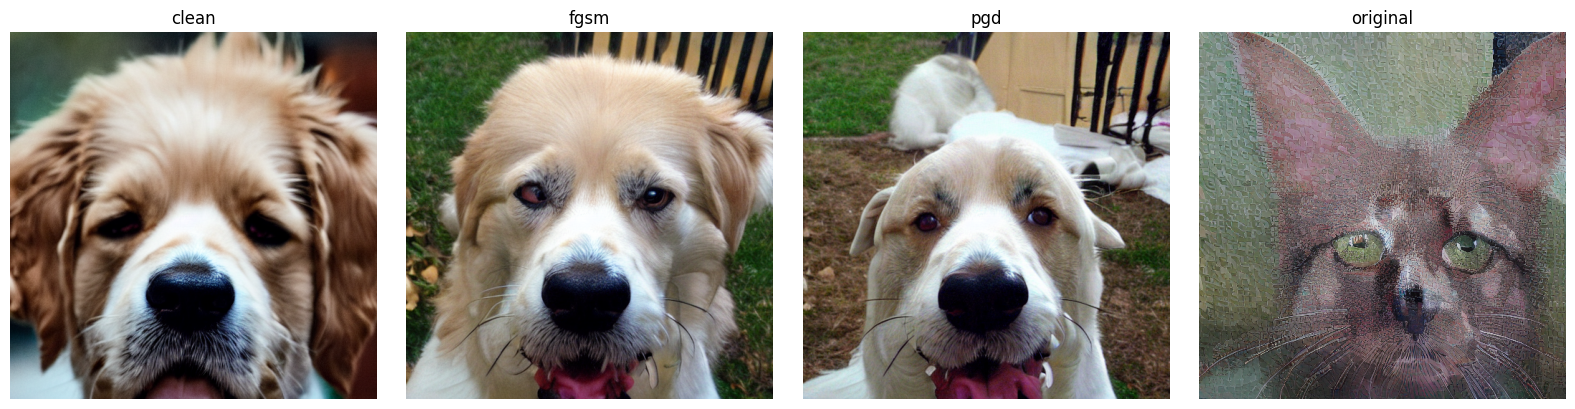

In [37]:
clean_dir = 'generated_samples/none'
method_dirs = {
    'fgsm': 'generated_samples/fgsm',
    'pgd': 'generated_samples/pgd',
    'original': 'generated_samples/original'
}
show_gen_poisoned_images(5, clean_dir, method_dirs)